# Bag of Words / Word2Vec

Most fundamental representation of text. Bag of words considers the frequency of words relative to size of text (text frequency). With each word having a probability to then compare different kinds of text based on frequency. E.g. spam contains higher frequency of certain words than non-spam so an algorithm can be applied on this data.

Word2Vec accounts for position of words to create a vector representation of that word.

https://medium.com/sfu-cspmp/catch-me-if-you-can-getting-the-true-meaning-out-of-big-cloud-of-texts-fe7bc75d1d5b

# Bigrams / Trigrams - TFIDF Decomposition to find Topics

Bigrams and Trigrams are two or three words frequently occurring together in a document. Some examples in my dataset include: ‘block based programming’, ‘visually impaired’, ‘screen reader’, ‘programming language’, ‘computer science’, etc. I used Gensim’s Phrases model to build and implement the bigrams and trigrams. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams or trigrams.

https://obianuju-c-okafor.medium.com/automatic-topic-classification-of-research-papers-using-the-nlp-topic-model-nmf-d4365987ec82

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)

In [ ]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)
# Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [ ]:
# de-tokenization, combine tokens together
detokenized_data = []
for i in range(len(dataset)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
dataset['clean_text']= detokenized_data
documents = dataset['clean_text']

This is the first step towards topic modelling. Each and every term and document in the dataset has to be represented as a vector. We will use sklearn’s TfidfVectorizer to create a document-term matrix using only 1000 terms (words) from our corpus. 

In [ ]:
#Set variable number of terms
no_terms = 1000
# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)
#get features
feature_names = vectorizer.get_feature_names()

The generated document-term matrix will be decomposed into multiple matrices. We will use sklearn’s decomposition model NMF to perform the task of matrix decomposition. The number of topics to be generated can be specified by using the n_components parameter. The resulting matrices derived after running the topic model are the document-topic matrix and term-topic matrix. In the term-topic matrix, sorting the rows in reverse, reveals the top terms for each topic.

In [ ]:
#Set variables number of topics and top words.
no_topics = 10
no_top_words = 10
# Function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):
    print("Model Result:")
    word_dict = {}
    for i in range(num_topics):
      #for each topic, obtain the largest values, and add the words they map to into the dictionary.
       words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
       words = [feature_names[key] for key in words_ids]
       word_dict['Topic # ' + '{:02d}'.format(i)] = words
    dict = pd.DataFrame(word_dict)
    dict.to_csv('%s.csv' % model_name)
    return dict
# Apply NMF topic model to document-term matrix
nmf_model = NMF(n_components=no_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(document_matrix)

# K-means Clustering of Text - Summarisation

Word2Vec vector representation of words and combined for sentences. Run K-means algorithm to find centers (which could be interpreted as topics) and select sentence vectors closest to the centers as the summarisation.

https://medium.com/@akankshagupta371/understanding-text-summarization-using-k-means-clustering-6487d5d37255

In [ ]:
import nltk
nltk.download('punkt')   # one time execution
from nltk.tokenize import sent_tokenize
sentence = sent_tokenize(text)

In [ ]:
import re
nltk.download('stopwords')  # one time execution
from nltk.corpus import stopwords
corpus = []
for i in range(len(sentence)):
    sen = re.sub('[^a-zA-Z]', " ", sentence[i])  
    sen = sen.lower()                            
    sen = sen.split()                         
    sen = ' '.join([i for i in sen if i not in stopwords.words('english')])   
    corpus.append(sen)

In [ ]:
from gensim.models import Word2Vec
all_words = [i.split() for i in corpus]
model = Word2Vec(all_words, min_count=1,size= 300)

In [ ]:
sent_vector=[]
for i in corpus:
    plus=0
    for j in i.split():
        plus+= model.wv[j]
    plus = plus/len(i.split())
    sent_vector.append(plus)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(sent_vector)

The sentence vector which has the minimum euclidean distance from the cluster centroid represents the whole group. These sentences from each cluster are ordered in the similar fashion as the original text to form a meaningful summary.

In [ ]:
from scipy.spatial import distance
my_list=[]
for i in range(n_clusters):
    my_dict={}
    
    for j in range(len(y_kmeans)):
        
        if y_kmeans[j]==i:
            my_dict[j] =  distance.euclidean(kmeans.cluster_centers_[i],sent_vector[j])
    min_distance = min(my_dict.values())
    my_list.append(min(my_dict, key=my_dict.get))
 
                            
for i in sorted(my_list):
    print(sentence[i])

# Topic Modelling with LDA

Latent Dirichlet Allocation (LDA) is part of Python's Gensim package.
LDA was first developed by Blei et al. in 2003. LDA is a generative probabilistic model similar to Naive Bayes. It represents topics as word probabilities and allows for uncovering latent or hidden topics as it clusters the words based on their co-occurrence in a respective document.

https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

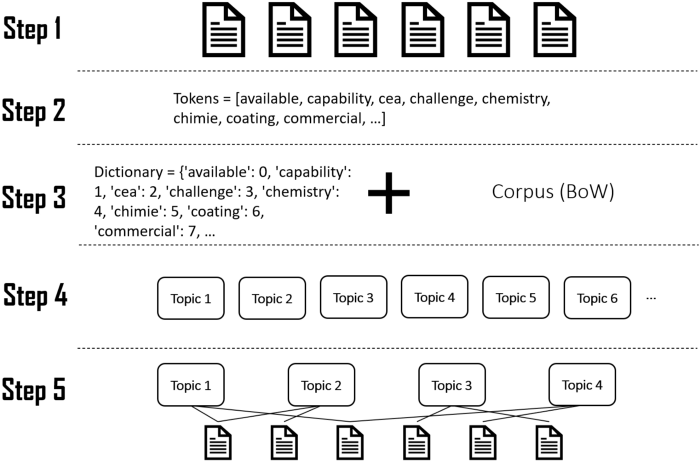

In [ ]:
# Install
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq

In [ ]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [ ]:
# Our spaCy model:
nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

In [ ]:
for summary in nlp.pipe(reports['summary']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [ ]:
# Add tokens to new column
reports['tokens'] = tokens
reports['tokens']

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

After having constructed the topics, a coherence score can be computed. The score measures the degree of semantic similarity between high scoring words in each topic. In this fashion, a coherence score can be computed for each iteration by inserting a varying number of topics.

A range of algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). Working with the gensim library makes computing these coherence measures for topic models fairly simple. I personally choose to implement C_v and C_umass. The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are fairly good, according to John McLevey

In [ ]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

When looking at the coherence using the C_umass or C_v algorithm, the best is usually the max. Looking at the graphs I choose to go with 5 topics, although no certain answer can be given.

In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

# Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
reports['summary'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

# Save the report
pyLDAvis.save_html(lda_display, 'index.html')

# Pre-trained Sentiment Classifiers

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically designed to detect sentiments expressed in social media.

pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1 or close to it with float operation).

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and 1 (most extreme positive). This is the most useful metric if you want a single measure of sentiment for a given sentence.

https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6

In [ ]:
#install vaderSentimentlibrary
pip install vaderSentiment

#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment